##**Determine whether the image is scenic or not from the image and the comment**##

Define the classifier : Must be the same as pretrained

In [1]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00


Saving Screenshot 2023-09-20 at 11.01.03 PM.png to Screenshot 2023-09-20 at 11.01.03 PM.png
User uploaded file "Screenshot 2023-09-20 at 11.01.03 PM.png" with length 1099377 bytes


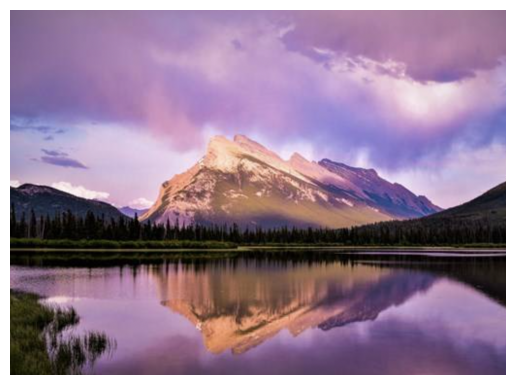

Enter the comment of the image : lake and clouds over lake with mountain
scenic


In [4]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab import files
from torchvision.io import read_image
import io
import torchvision


processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ScenicClassifier(torch.nn.Module):
  def __init__(self, enc_features: int):
    super().__init__()
    self.embedding = model.vilt
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(enc_features, 32, bias=False),
        # torch.nn.ReLU(),
        # torch.nn.Linear(64, 16, bias=False),
        torch.nn.Linear(32, 2, bias=False),
        # torch.nn.ReLU()
        )

  def forward(self, encodings):
    embeds = self.embedding(**encodings)['pooler_output']
    logits = self.classifier(embeds)

    return logits



model_url = 'https://fypphotos.s3.amazonaws.com/vilt_mode.pt'

classifier = ScenicClassifier(768)
model_weights = torch.hub.load_state_dict_from_url(model_url, map_location=torch.device('cpu'))
classifier.load_state_dict(model_weights)
classifier.eval()



uploaded = files.upload()
img_resize = transforms.Resize((384, 512))
label = ['not scenic', 'scenic']

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

  # load the image and convert it to RGB
  uploaded[fn]
  img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  comment = input("Enter the comment of the image : ")
  comment = comment.lower()
  encoding = processor(img, comment, return_tensors='pt', padding='max_length', truncation=True)

  predict = classifier(encoding)
  print(label[torch.argmax(torch.squeeze(predict))])